In [ ]:
import os
import glob
import random
import math
import sys
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (LayerNormalization, Dropout, Add, Dense,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape,
                                     Permute, Activation, Lambda, Conv2D, Concatenate, multiply,
                                     BatchNormalization, MaxPooling2D)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import mne
from scipy.signal import resample

###############################################
# Pairing PSG and Hypnogram Files
###############################################
dataset_path = "/kaggle/input/sleepedf/sleepEDF/sleep-cassette"
psg_files = sorted(glob.glob(os.path.join(dataset_path, "*-PSG.edf")))
hypnogram_files = sorted(glob.glob(os.path.join(dataset_path, "*-Hypnogram.edf")))

psg_hypnogram_pairs = {}
for psg_file in psg_files:
    psg_base = os.path.basename(psg_file)
    identifier = psg_base[:6]
    matching = [h for h in hypnogram_files if os.path.basename(h)[:6] == identifier]
    if matching:
        psg_hypnogram_pairs[psg_file] = matching[0]

if not psg_hypnogram_pairs:
    print("No matching PSG and Hypnogram pairs found in:", dataset_path)
    sys.exit(1)

selected_psg = random.choice(list(psg_hypnogram_pairs.keys()))
selected_hypnogram = psg_hypnogram_pairs[selected_psg]
print("Selected PSG file:", selected_psg)
print("Selected Hypnogram file:", selected_hypnogram)

###############################################
# Additional Attention Blocks
###############################################
def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True):
    in_sh = in_layer.shape
    in_len = len(in_sh)
    expanded_axis = 2

    if attention_model == 'mha':
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam':
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))

    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    if vanilla:
        x = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    else:
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    x = Dropout(0.3)(x)
    mha_feature = Add()([input_feature, x])
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

def se_block(input_feature, ratio=8, residual=False, apply_to_input=True):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    if ratio != 0:
        se_feature = Dense(channel // ratio, activation='relu',
                           kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid',
                       kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
    if apply_to_input:
        se_feature = multiply([input_feature, se_feature])
    if residual:
        se_feature = Add()([se_feature, input_feature])
    return se_feature

def cbam_block(input_feature, ratio=8, residual=False):
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    if residual:
        cbam_feature = Add()([input_feature, cbam_feature])
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    shared_layer_one = Dense(channel // ratio, activation='relu',
                             kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    return multiply([input_feature, cbam_feature])

###############################################
# Preprocessing Functions
###############################################
def standardize_raw_data(X_train, X_test):
    n_channels = X_train.shape[1]
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_train[:, ch, :] = scaler.fit_transform(X_train[:, ch, :])
        X_test[:, ch, :] = scaler.transform(X_test[:, ch, :])
    return X_train, X_test

###############################################
# 1. Load PSG & Hypnogram Files and Prepare Data
###############################################
raw = mne.io.read_raw_edf(selected_psg, preload=True)
annotations = mne.read_annotations(selected_hypnogram)
raw.set_annotations(annotations)

selected_channels = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']
raw.pick_channels(selected_channels)

epoch_duration = 30  # seconds
sfreq = raw.info['sfreq']
epoch_samples = int(epoch_duration * sfreq)

sleep_stage_map = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 4,
    "Sleep stage R": 5
}

epochs_list = []
labels_list = []
for annot in annotations:
    if annot['description'] in sleep_stage_map:
        onset = int(annot['onset'] * sfreq)
        if onset + epoch_samples <= raw.n_times:
            epoch_data = raw[:, onset:onset + epoch_samples][0]
            epoch_data = (epoch_data - np.mean(epoch_data)) / np.std(epoch_data)
            epochs_list.append(epoch_data)
            labels_list.append(sleep_stage_map[annot['description']])

X = np.array(epochs_list, dtype=np.float32)  # Shape: (n_epochs, channels, epoch_samples)
y = np.array(labels_list)

new_timepoints = 384
n_samples, n_channels, _ = X.shape
X_resampled = np.empty((n_samples, n_channels, new_timepoints))
for i in range(n_samples):
    for ch in range(n_channels):
        X_resampled[i, ch, :] = resample(X[i, ch, :], new_timepoints)
X = X_resampled

x_eon = np.log1p(np.abs(X)) * np.sign(X)

X_train, X_test, y_train, y_test = train_test_split(x_eon, y, test_size=0.2, random_state=42)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)
X_train, X_test = standardize_raw_data(X_train, X_test)

###############################################
# 2. Continuous Wavelet Transform (CWT) Preprocessing
###############################################
def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)
        transformed.append(sample_cwt)
    return np.array(transformed)

scales = np.arange(1, 31)  # 30 scales → output height of 30
wavelet = 'morl'
X_train_cwt = apply_cwt(X_train, scales, wavelet)
X_test_cwt  = apply_cwt(X_test, scales, wavelet)

print("Transformed training data shape:", X_train_cwt.shape)
print("Transformed test data shape:", X_test_cwt.shape)

###############################################
# 3. Improved 2D CNN Model with Additional Blocks
###############################################
def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    
    # First Convolutional Block
    x = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Second Convolutional Block
    x = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Third Convolutional Block
    x = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Apply Attention Module (CBAM)
    x = attention_block(x, attention_model='cbam', ratio=8, residual=True, apply_to_input=True)
    
    # Global Pooling and Dense Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model((30, 384, 4), num_classes=6)
model.summary()

###############################################
# 4. Prepare Labels, Train the Model, and Evaluate
###############################################
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=6)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=6)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

history = model.fit(X_train_cwt, y_train_cat, epochs=100, batch_size=32,
                    validation_data=(X_test_cwt, y_test_cat),
                    callbacks=[reduce_lr, early_stop, checkpoint])

# Evaluate the model
y_pred_prob = model.predict(X_test_cwt)
y_pred = np.argmax(y_pred_prob, axis=1)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", history.history['accuracy'][-1])
print("\nValidation Accuracy:", history.history['val_accuracy'][-1])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest Accuracy:", test_accuracy)



🔹 Training Fold 1...



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.2744 - loss: 1.8606 - val_accuracy: 0.6041 - val_loss: 1.5231 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5155 - loss: 1.4336 - val_accuracy: 0.7157 - val_loss: 0.9622 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6384 - loss: 1.0100 - val_accuracy: 0.7157 - val_loss: 0.7691 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7181 - loss: 0.8014 - val_accuracy: 0.8071 - val_loss: 0.5479 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7697 - loss: 0.6443 - val_accuracy: 0.8477 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8082 - loss: 0.4745 - val_accuracy: 0.9086 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8399 - loss: 0.4547 - val_accuracy

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set dataset path
data_dir = "/kaggle/input/ckplus/CK+48"

# Define image parameters
img_size = (48, 48)
batch_size = 32

# Load dataset
X, y = [], []
class_names = sorted(os.listdir(data_dir))
for label, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = keras.utils.load_img(img_path, target_size=img_size, color_mode='grayscale')
        img = keras.utils.img_to_array(img) / 255.0
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50, verbose=1)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\n📊 Test Accuracy: {test_accuracy * 100:.2f}%")

# Save model
model.save("trained_model.keras")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.2413 - loss: 1.8507 - val_accuracy: 0.4518 - val_loss: 1.7108
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4645 - loss: 1.5945 - val_accuracy: 0.6396 - val_loss: 1.1952
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5977 - loss: 1.1747 - val_accuracy: 0.6904 - val_loss: 0.8518
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6905 - loss: 0.8472 - val_accuracy: 0.8173 - val_loss: 0.6839
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7880 - loss: 0.6151 - val_accuracy: 0.8680 - val_loss: 0.4902
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8171 - loss: 0.5394 - val_accuracy: 0.8883 - val_loss: 0.4008
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8467 - loss: 0.4464 - val_accuracy: 0.9036 - val_loss: 0.3087
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.3944 - val_accuracy: 0.9340 - val_loss: 0.2203
E

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

# Custom Spatial Attention Layer
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        # Create the Conv2D layer only once
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Compute average and max pool along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return inputs * attention

# Build Model with Spatial Attention
def build_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = SpatialAttention()(x)  # Apply spatial attention

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.models.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Load CK+ Dataset
data_dir = "/kaggle/input/ckplus/CK+48"
img_size = (48, 48)
classes = sorted(os.listdir(data_dir))
X, y = [], []

for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            # Load image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X, dtype='float32').reshape(-1, 48, 48, 1) / 255.0  # Normalize pixel values
y = np.array(y)

# Split dataset: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Build and Train the Model
model = build_model()
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=1)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\n📊 Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the Model as .keras
model.save("trained_model.keras")


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.2040 - loss: 1.8980 - val_accuracy: 0.2538 - val_loss: 1.8034
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2873 - loss: 1.7830 - val_accuracy: 0.4162 - val_loss: 1.6490
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4178 - loss: 1.6221 - val_accuracy: 0.6142 - val_loss: 1.1599
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5768 - loss: 1.2005 - val_accuracy: 0.6954 - val_loss: 0.8634
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6560 - loss: 0.9044 - val_accuracy: 0.7817 - val_loss: 0.7302
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7032 - loss: 0.7665 - val_accuracy: 0.7766 - val_loss: 0.6587
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7479 - loss: 0.7061 - val_accuracy: 0.8426 - val_loss: 0.4453
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7863 - loss: 0.5457 - val_accuracy: 0.8832 - val_los

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Dataset path for CK+48 which contains 7 subfolders (each for one class)
dataset_path = '/kaggle/input/ckplus/CK+48'

# Get class names (subfolder names)
class_names = sorted(os.listdir(dataset_path))
num_classes = len(class_names)  # Should be 7

# Get file paths and corresponding labels
filepaths = []
labels = []
for idx, class_name in enumerate(class_names):
    folder = os.path.join(dataset_path, class_name)
    for fname in os.listdir(folder):
        file_path = os.path.join(folder, fname)
        filepaths.append(file_path)
        labels.append(idx)
        
filepaths = np.array(filepaths)
labels = np.array(labels)

# Load images and convert them to arrays of shape (48,48,1)
images = []
for fp in filepaths:
    # Ensure image is loaded in grayscale with target size 48x48
    img = load_img(fp, color_mode='grayscale', target_size=(48,48))
    img_array = img_to_array(img)
    images.append(img_array)
images = np.array(images)

# Normalize images
images = images / 255.0

# Define data augmentation
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.087),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal")
])

def augment(image, label):
    return data_augmentation(image, training=True), label

# Define custom model components
def entry_flow(inputs):
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    return x

def middle_flow(x, num_blocks=8):
    previous_block_activation = x
    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.add([x, previous_block_activation])
        previous_block_activation = x

    return x

def exit_flow(x, num_classes=7):
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
    return x

# Hyperparameters and training schedule
batch_size = 64
epochs_run1 = 100
epochs_run2 = 30
epochs_run3 = 20

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=123)
test_accuracy_list = []

fold_no = 1
for train_index, test_index in kf.split(images, labels):
    print(f"Processing fold #{fold_no}...")
    train_images, test_images = images[train_index], images[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(1000).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)
    
    # Apply data augmentation to training dataset
    train_ds = train_ds.map(augment)
    
    # Build the model
    inputs = keras.Input(shape=(48, 48, 1))
    x = entry_flow(inputs)
    x = middle_flow(x)
    outputs = exit_flow(x, num_classes=num_classes)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
    
    # Training Run #1
    history1 = model.fit(train_ds, validation_data=test_ds, epochs=epochs_run1, callbacks=[checkpoint])
    
    # Training Run #2
    model.optimizer.learning_rate.assign(0.0001)
    history2 = model.fit(train_ds, validation_data=test_ds, epochs=epochs_run2, callbacks=[checkpoint])
    
    # Training Run #3
    model.optimizer.learning_rate.assign(0.00001)
    history3 = model.fit(train_ds, validation_data=test_ds, epochs=epochs_run3, callbacks=[checkpoint])
    
    # Evaluate model on test data for this fold
    scores = model.evaluate(test_ds, verbose=0)
    print(f"Fold #{fold_no} Test Accuracy: {scores[1]:.4f}")
    test_accuracy_list.append(scores[1])
    
    fold_no += 1

# Calculate and print the mean test accuracy across all folds
mean_test_accuracy = np.mean(test_accuracy_list)
print(f"\nMean Test Accuracy over 5 folds: {mean_test_accuracy:.4f}")


Processing fold #1...
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2047 - loss: 2.0699 - val_accuracy: 0.1523 - val_loss: 2.0728
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3242 - loss: 1.9932 - val_accuracy: 0.1523 - val_loss: 2.0682
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4586 - loss: 1.5947 - val_accuracy: 0.0761 - val_loss: 2.0645
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4983 - loss: 1.4990 - val_accuracy: 0.0761 - val_loss: 2.0627
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5427 - loss: 1.3639 - val_accuracy: 0.0761 - val_loss: 2.0616
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6465 - loss: 1.1784 - val_accuracy: 0.0761 - val_loss: 2.0632
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6018 - loss: 1.2034 - val_accuracy: 0.0761 - val_loss: 2.0610
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6026 - loss: 1.13


Processing Fold #1


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 24, 24, 32)     │            320 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_180   │ (None, 24, 24, 32)     │            128 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_180            │ (None, 24, 24, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 24, 24, 64)     │         18,496 │ activation_180[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_181   │ (None, 24, 24, 64)     │            256 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_181            │ (None, 24, 24, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_182            │ (None, 24, 24, 64)     │              0 │ activation_181[0][0]   │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_170      │ (None, 24, 24, 128)    │          8,896 │ activation_182[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_182   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_170[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_183            │ (None, 24, 24, 128)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_171      │ (None, 24, 24, 128)    │         17,664 │ activation_183[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_183   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_171[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 12, 12, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)       

 Total params: 20,894,696 (79.71 MB)

 Trainable params: 20,844,440 (79.52 MB)

 Non-trainable params: 50,256 (196.31 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2672 - loss: 2.0086
Epoch 1: val_accuracy improved from -inf to 0.25888, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.2693 - loss: 2.0060 - val_accuracy: 0.2589 - val_loss: 2.0697
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2969 - loss: 2.0033
Epoch 2: val_accuracy did not improve from 0.25888
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2969 - loss: 2.0033 - val_accuracy: 0.2589 - val_loss: 2.0694
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3253 - loss: 1.8032
Epoch 3: val_accuracy did not improve from 0.25888
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3265 - loss: 1.8036 - val_accuracy: 0.2589 - val_loss: 2.0638
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4844 - loss: 1.5340
Epoch 4: val_accuracy did not improve from 0.25888
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4844 - loss: 1.5340 - val_accuracy: 0.2589 - val_loss: 2.0638
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4336 - loss: 1.6306
Epoch 5: val_accuracy did not improve from 0.25888
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4359 - loss: 1.6239 - val_accuracy: 0.2589 - val_loss: 2.0606
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7188 - loss: 1.1923
Epoch 6: val_accuracy did not improve from 0.25888
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7188 - loss: 1.1923 - val_accuracy: 0.2589 - val_loss: 2.0600
Ep

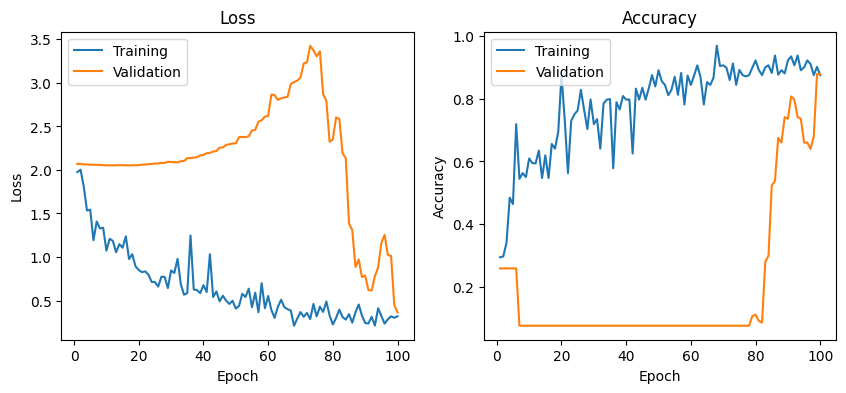

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9538 - loss: 0.1934
Epoch 1: val_accuracy improved from -inf to 0.85787, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9539 - loss: 0.1925 - val_accuracy: 0.8579 - val_loss: 0.4633
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9531 - loss: 0.1606
Epoch 2: val_accuracy improved from 0.85787 to 0.87310, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9531 - loss: 0.1606 - val_accuracy: 0.8731 - val_loss: 0.4515
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9541 - loss: 0.1505
Epoch 3: val_accuracy improved from 0.87310 to 0.93401, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.9541 - loss: 0.1501 - val_accuracy: 0.9340 - val_loss: 0.2429
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0545
Epoch 4: val_ac

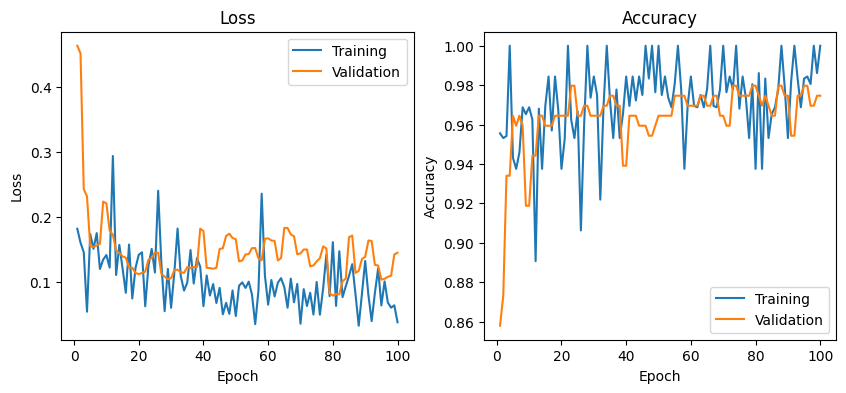

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9875 - loss: 0.0606  
Epoch 1: val_accuracy improved from -inf to 0.97462, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9870 - loss: 0.0613 - val_accuracy: 0.9746 - val_loss: 0.1407
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9844 - loss: 0.0441
Epoch 2: val_accuracy did not improve from 0.97462
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0441 - val_accuracy: 0.9746 - val_loss: 0.1400
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9846 - loss: 0.0610
Epoch 3: val_accuracy did not improve from 0.97462
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9848 - loss: 0.0607 - val_accuracy: 0.9746 - val_loss: 0.1304
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9844 - loss: 0.0864
Epoch 4: val_accuracy did not improve from 0.97462
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - 

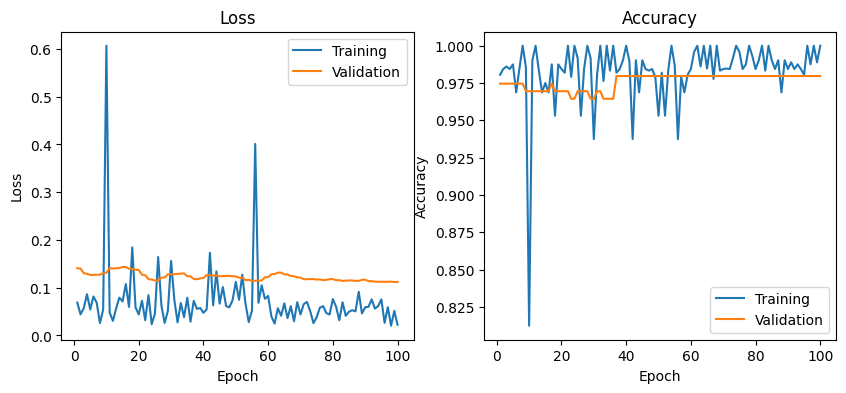

ValueError: Layer "functional_6" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 48, 48, 1) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None, 7) dtype=float32>]

In [3]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import gdown  # For Google Drive download

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Load dataset from directory (/kaggle/input/ckplus/CK+48) which contains 7 subfolders
dataset_path = '/kaggle/input/ckplus/CK+48'
class_names = sorted(os.listdir(dataset_path))
filepaths = []
labels = []
for idx, class_name in enumerate(class_names):
    folder = os.path.join(dataset_path, class_name)
    for fname in os.listdir(folder):
        file_path = os.path.join(folder, fname)
        filepaths.append(file_path)
        labels.append(idx)
        
filepaths = np.array(filepaths)
labels = np.array(labels)

# Load images (48x48 grayscale) and normalize
images = []
for fp in filepaths:
    img = load_img(fp, color_mode='grayscale', target_size=(48, 48))
    img_array = img_to_array(img)
    images.append(img_array)
images = np.array(images)
images = images / 255.0

# Convert labels to one-hot vectors (7 classes)
y = to_categorical(labels, num_classes=7)

# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define entry flow
def entry_flow(inputs):
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    return x

# Define middle flow
def middle_flow(x, num_blocks=8):
    previous_block_activation = x

    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.add([x, previous_block_activation])
        previous_block_activation = x

    return x

# Define attention layer
def attention_layer(inputs):
    attention = layers.Conv2D(1, (1, 1), activation="sigmoid")(inputs)
    return layers.multiply([inputs, attention])

# Define exit flow
def exit_flow(x, num_classes=7):
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = 'softmax' if num_classes > 1 else 'sigmoid'
    return layers.Dense(num_classes, activation=activation, kernel_regularizer=regularizers.l2(0.01))(x)

# 5-fold cross validation: Each fold uses 80% of data for training and 20% for test
kf = KFold(n_splits=5, shuffle=True, random_state=123)
fold_no = 1
test_accuracy_list = []

for train_index, test_index in kf.split(images):
    print(f"\nProcessing Fold #{fold_no}")
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create data generators
    batch_size = 64
    train_loader = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    validation_loader = (X_test, y_test)
    
    # Build model
    inputs = keras.Input(shape=(48, 48, 1))
    x = entry_flow(inputs)
    x = middle_flow(x)
    x = attention_layer(x)  # Adding attention layer
    outputs = exit_flow(x)
    xception = keras.Model(inputs, outputs)
    
    # Print model summary
    xception.summary()
    
    # ------------------ First Training Block (LR = 0.001) ------------------
    opt = tf.keras.optimizers.Adam(0.001)
    xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                                 save_best_only=True, mode='max', verbose=1)
    
    epochs = 100
    h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                      validation_data=validation_loader, epochs=epochs, callbacks=[checkpoint])
    
    history = h1.history
    n_epochs = len(history['loss'])
    plt.figure(figsize=[10, 4])
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    # ------------------ Second Training Block (LR = 0.0001) ------------------
    opt = tf.keras.optimizers.Adam(0.0001)
    xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                                 save_best_only=True, mode='max', verbose=1)
    
    epochs = 100
    h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                      validation_data=validation_loader, epochs=epochs, callbacks=[checkpoint])
    
    history = h1.history
    n_epochs = len(history['loss'])
    plt.figure(figsize=[10, 4])
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    # ------------------ Third Training Block (LR = 0.00001) ------------------
    opt = tf.keras.optimizers.Adam(0.00001)
    xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                                 save_best_only=True, mode='max', verbose=1)
    
    epochs = 100
    h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                      validation_data=validation_loader, epochs=epochs, callbacks=[checkpoint])
    
    history = h1.history
    n_epochs = len(history['loss'])
    plt.figure(figsize=[10, 4])
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    # Evaluate the model on the test data for this fold
    scores = xception.evaluate(validation_loader, verbose=0)
    print(f"Fold #{fold_no} Test Accuracy: {scores[1]:.4f}")
    test_accuracy_list.append(scores[1])
    
    fold_no += 1

# Calculate and print the mean test accuracy over all folds
mean_test_accuracy = np.mean(test_accuracy_list)
print(f"\nMean Test Accuracy over 5 folds: {mean_test_accuracy:.4f}")



Processing Fold #1


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 24, 24, 32)     │            320 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_216   │ (None, 24, 24, 32)     │            128 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_216            │ (None, 24, 24, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 24, 24, 64)     │         18,496 │ activation_216[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_217   │ (None, 24, 24, 64)     │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_217            │ (None, 24, 24, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_218            │ (None, 24, 24, 64)     │              0 │ activation_217[0][0]   │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_204      │ (None, 24, 24, 128)    │          8,896 │ activation_218[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_218   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_204[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_219            │ (None, 24, 24, 128)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_205      │ (None, 24, 24, 128)    │         17,664 │ activation_219[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_219   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_205[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 12, 12, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)       

 Total params: 20,894,696 (79.71 MB)

 Trainable params: 20,844,440 (79.52 MB)

 Non-trainable params: 50,256 (196.31 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2466 - loss: 2.0382
Epoch 1: val_accuracy improved from -inf to 0.25888, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2484 - loss: 2.0355 - val_accuracy: 0.2589 - val_loss: 2.0651
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2969 - loss: 2.0078
Epoch 2: val_accuracy did not improve from 0.25888
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2969 - loss: 2.0078 - val_accuracy: 0.2589 - val_loss: 2.0647
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3463 - loss: 1.8516
Epoch 3: val_accuracy did not improve from 0.25888
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3463 - loss: 1.8499 - val_accuracy: 0.1523 - val_loss: 2.0576
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3750 - loss: 1.7291
Epoch 4: val_accuracy did not improve from 0.25888
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3750 - lo

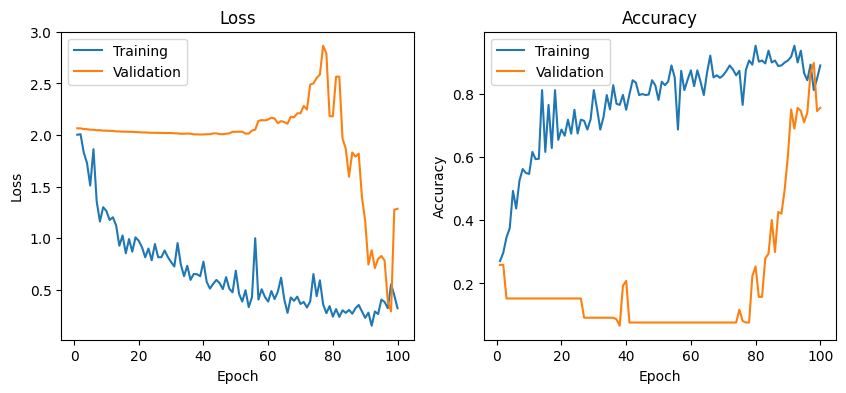

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8803 - loss: 0.3654
Epoch 1: val_accuracy improved from -inf to 0.88325, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8797 - loss: 0.3650 - val_accuracy: 0.8832 - val_loss: 0.4086
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8281 - loss: 0.4028
Epoch 2: val_accuracy did not improve from 0.88325
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8281 - loss: 0.4028 - val_accuracy: 0.8832 - val_loss: 0.3790
Epoch 3/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9133 - loss: 0.2752
Epoch 3: val_accuracy improved from 0.88325 to 0.90355, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9151 - loss: 0.2718 - val_accuracy: 0.9036 - val_loss: 0.2997
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9688 - loss: 0.1920
Epoch 4: val_accuracy did not improve from 0.90355
12/12 ━━━━━━━

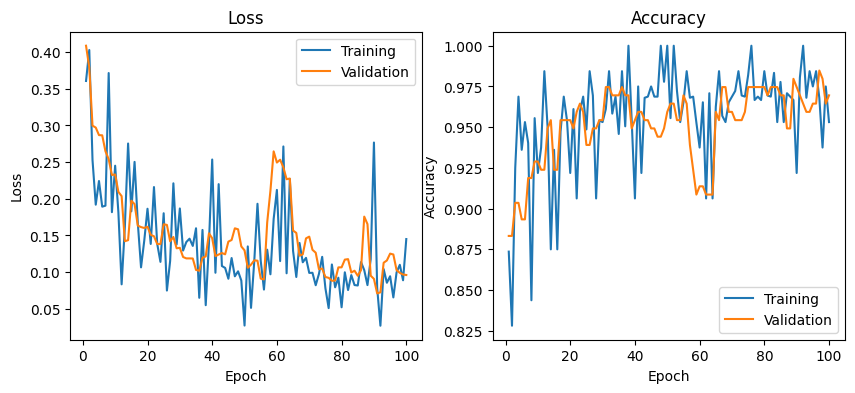

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9764 - loss: 0.0840  
Epoch 1: val_accuracy improved from -inf to 0.97462, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9765 - loss: 0.0837 - val_accuracy: 0.9746 - val_loss: 0.0852
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9844 - loss: 0.0711
Epoch 2: val_accuracy did not improve from 0.97462
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0711 - val_accuracy: 0.9746 - val_loss: 0.0853
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9754 - loss: 0.0717
Epoch 3: val_accuracy did not improve from 0.97462
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9754 - loss: 0.0721 - val_accuracy: 0.9746 - val_loss: 0.0854
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9531 - loss: 0.1240
Epoch 4: val_accuracy did not improve from 0.97462
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - 

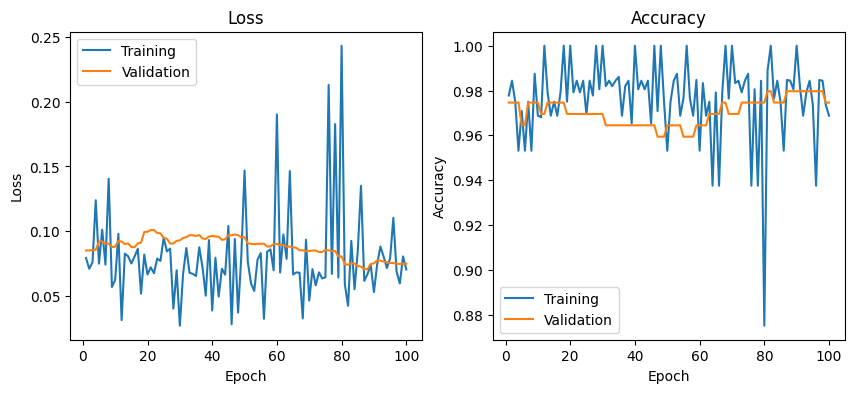

Fold #1 Test Accuracy: 0.9746

Processing Fold #2


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 24, 24, 32)     │            320 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_252   │ (None, 24, 24, 32)     │            128 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_252            │ (None, 24, 24, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 24, 24, 64)     │         18,496 │ activation_252[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_253   │ (None, 24, 24, 64)     │            256 │ conv2d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_253            │ (None, 24, 24, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_254            │ (None, 24, 24, 64)     │              0 │ activation_253[0][0]   │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_238      │ (None, 24, 24, 128)    │          8,896 │ activation_254[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_254   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_238[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_255            │ (None, 24, 24, 128)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_239      │ (None, 24, 24, 128)    │         17,664 │ activation_255[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_255   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_239[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 12, 12, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)       

 Total params: 20,894,696 (79.71 MB)

 Trainable params: 20,844,440 (79.52 MB)

 Non-trainable params: 50,256 (196.31 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2188 - loss: 2.0090  
Epoch 1: val_accuracy improved from -inf to 0.27551, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.2209 - loss: 2.0058 - val_accuracy: 0.2755 - val_loss: 2.0675
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2656 - loss: 1.9256
Epoch 2: val_accuracy did not improve from 0.27551
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2656 - loss: 1.9256 - val_accuracy: 0.2755 - val_loss: 2.0666
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3320 - loss: 1.8194
Epoch 3: val_accuracy did not improve from 0.27551
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3323 - loss: 1.8212 - val_accuracy: 0.2755 - val_loss: 2.0628
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4219 - loss: 1.7644
Epoch 4: val_accuracy did not improve from 0.27551
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4219 - 

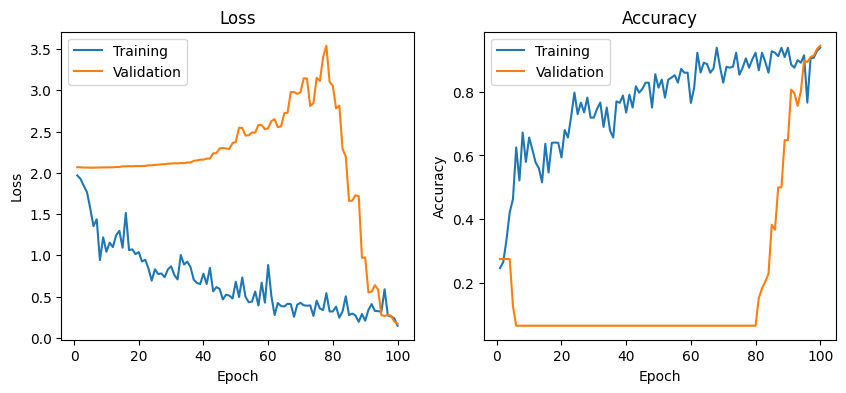

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9387 - loss: 0.1820
Epoch 1: val_accuracy improved from -inf to 0.96429, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9387 - loss: 0.1825 - val_accuracy: 0.9643 - val_loss: 0.1337
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9688 - loss: 0.1183
Epoch 2: val_accuracy improved from 0.96429 to 0.96939, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9688 - loss: 0.1183 - val_accuracy: 0.9694 - val_loss: 0.1342
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9587 - loss: 0.1584
Epoch 3: val_accuracy did not improve from 0.96939
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9578 - loss: 0.1614 - val_accuracy: 0.9388 - val_loss: 0.1740
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0512
Epoch 4: val_accuracy did not improve from 0.96939
12/12 ━━━━━━━

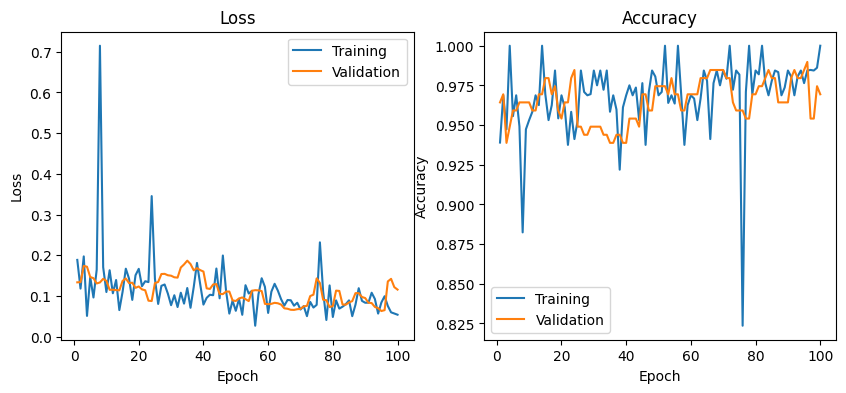

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9791 - loss: 0.0895
Epoch 1: val_accuracy improved from -inf to 0.96939, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9789 - loss: 0.0893 - val_accuracy: 0.9694 - val_loss: 0.1044
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0354
Epoch 2: val_accuracy did not improve from 0.96939
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0354 - val_accuracy: 0.9694 - val_loss: 0.1039
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9704 - loss: 0.1265
Epoch 3: val_accuracy did not improve from 0.96939
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9708 - loss: 0.1245 - val_accuracy: 0.9694 - val_loss: 0.0989
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9375 - loss: 0.1465
Epoch 4: val_accuracy did not improve from 0.96939
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - lo

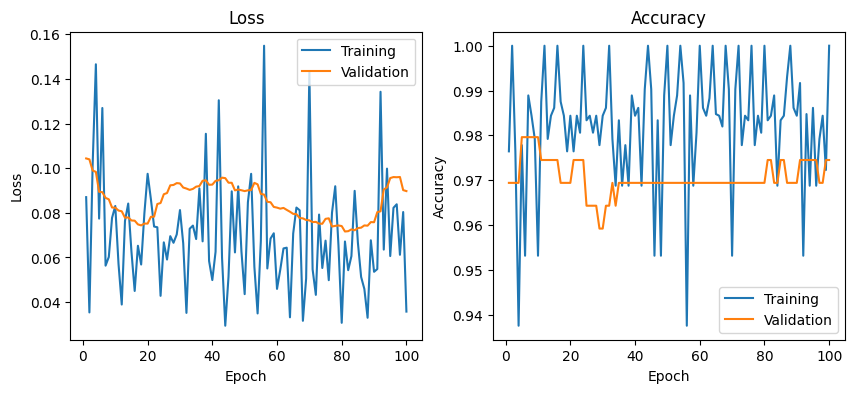

Fold #2 Test Accuracy: 0.9745

Processing Fold #3


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 24, 24, 32)     │            320 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_288   │ (None, 24, 24, 32)     │            128 │ conv2d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_288            │ (None, 24, 24, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 24, 24, 64)     │         18,496 │ activation_288[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_289   │ (None, 24, 24, 64)     │            256 │ conv2d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_289            │ (None, 24, 24, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_290            │ (None, 24, 24, 64)     │              0 │ activation_289[0][0]   │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_272      │ (None, 24, 24, 128)    │          8,896 │ activation_290[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_290   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_272[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_291            │ (None, 24, 24, 128)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_273      │ (None, 24, 24, 128)    │         17,664 │ activation_291[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_291   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_273[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 12, 12, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)       

 Total params: 20,894,696 (79.71 MB)

 Trainable params: 20,844,440 (79.52 MB)

 Non-trainable params: 50,256 (196.31 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1835 - loss: 2.0807 
Epoch 1: val_accuracy improved from -inf to 0.24490, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.1871 - loss: 2.0800 - val_accuracy: 0.2449 - val_loss: 2.0683
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2969 - loss: 2.0708
Epoch 2: val_accuracy did not improve from 0.24490
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2969 - loss: 2.0708 - val_accuracy: 0.2449 - val_loss: 2.0676
Epoch 3/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3166 - loss: 1.8811
Epoch 3: val_accuracy did not improve from 0.24490
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3193 - loss: 1.8745 - val_accuracy: 0.2449 - val_loss: 2.0617
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4062 - loss: 1.7603
Epoch 4: val_accuracy did not improve from 0.24490
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4062 - l

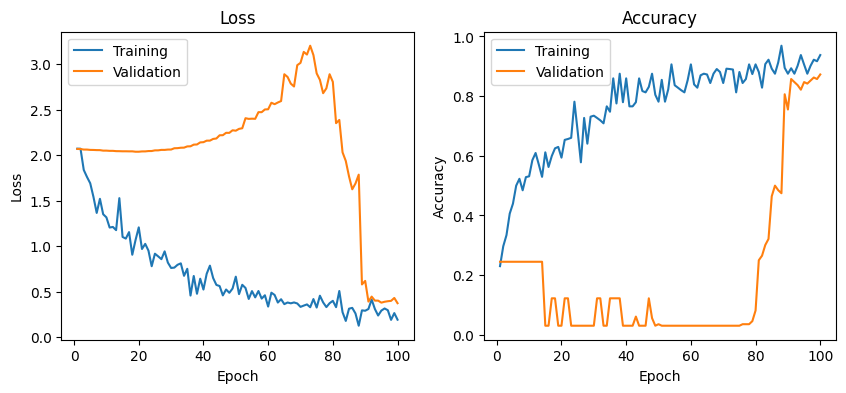

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9508 - loss: 0.1792
Epoch 1: val_accuracy improved from -inf to 0.90306, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9502 - loss: 0.1820 - val_accuracy: 0.9031 - val_loss: 0.3116
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9531 - loss: 0.1579
Epoch 2: val_accuracy did not improve from 0.90306
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.1579 - val_accuracy: 0.9031 - val_loss: 0.3085
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9381 - loss: 0.2080
Epoch 3: val_accuracy improved from 0.90306 to 0.93367, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9386 - loss: 0.2060 - val_accuracy: 0.9337 - val_loss: 0.2385
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9531 - loss: 0.1722
Epoch 4: val_accuracy did not improve from 0.93367
12/12 ━━━━━━━

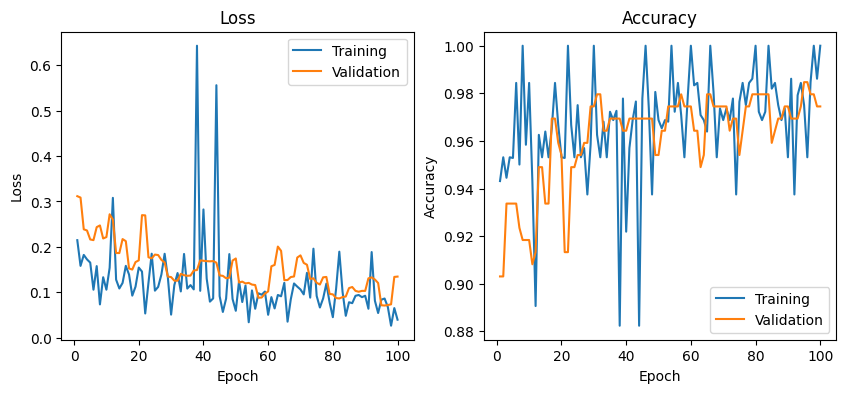

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9907 - loss: 0.0633
Epoch 1: val_accuracy improved from -inf to 0.97449, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9903 - loss: 0.0640 - val_accuracy: 0.9745 - val_loss: 0.1258
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9688 - loss: 0.0903
Epoch 2: val_accuracy did not improve from 0.97449
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0903 - val_accuracy: 0.9745 - val_loss: 0.1253
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9703 - loss: 0.0886
Epoch 3: val_accuracy did not improve from 0.97449
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9708 - loss: 0.0885 - val_accuracy: 0.9745 - val_loss: 0.1188
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0573
Epoch 4: val_accuracy did not improve from 0.97449
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - lo

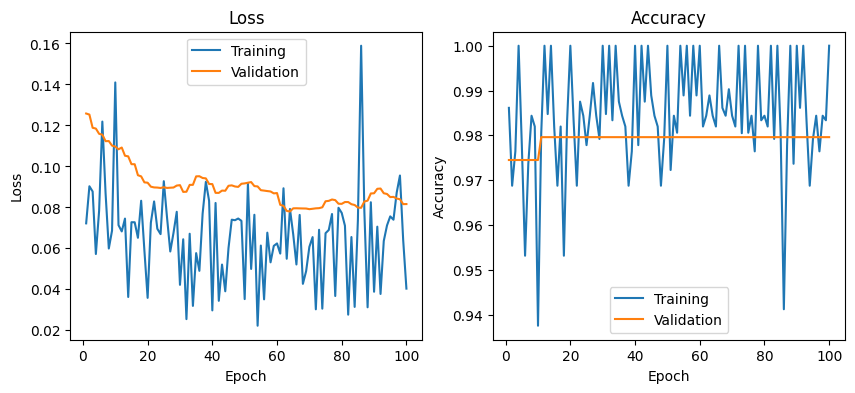

Fold #3 Test Accuracy: 0.9796

Processing Fold #4


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 24, 24, 32)     │            320 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_324   │ (None, 24, 24, 32)     │            128 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_324            │ (None, 24, 24, 32)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 24, 24, 64)     │         18,496 │ activation_324[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_325   │ (None, 24, 24, 64)     │            256 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_325            │ (None, 24, 24, 64)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_326            │ (None, 24, 24, 64)     │              0 │ activation_325[0][0]   │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_306      │ (None, 24, 24, 128)    │          8,896 │ activation_326[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_326   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_306[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_327            │ (None, 24, 24, 128)    │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_307      │ (None, 24, 24, 128)    │         17,664 │ activation_327[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_327   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_307[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_36          │ (None, 12, 12, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)       

 Total params: 20,894,696 (79.71 MB)

 Trainable params: 20,844,440 (79.52 MB)

 Non-trainable params: 50,256 (196.31 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2345 - loss: 2.0290
Epoch 1: val_accuracy improved from -inf to 0.23980, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.2369 - loss: 2.0283 - val_accuracy: 0.2398 - val_loss: 2.0676
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2031 - loss: 1.9649
Epoch 2: val_accuracy did not improve from 0.23980
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2031 - loss: 1.9649 - val_accuracy: 0.2398 - val_loss: 2.0671
Epoch 3/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3605 - loss: 1.8324
Epoch 3: val_accuracy did not improve from 0.23980
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3625 - loss: 1.8299 - val_accuracy: 0.2398 - val_loss: 2.0646
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3281 - loss: 1.6936
Epoch 4: val_accuracy did not improve from 0.23980
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3281 - lo

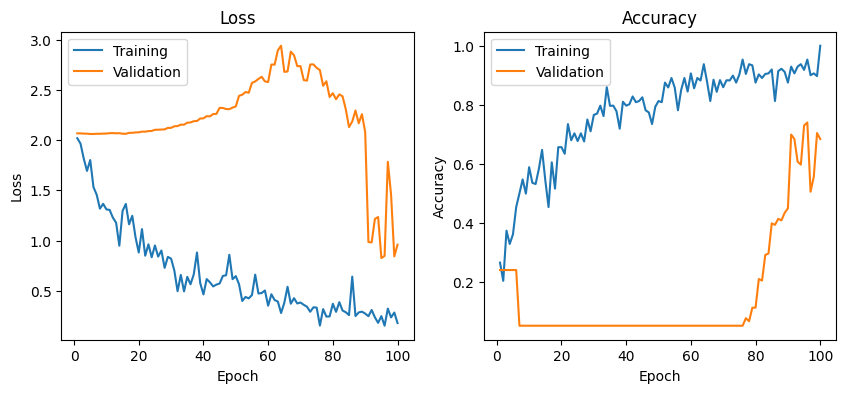

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9279 - loss: 0.2553
Epoch 1: val_accuracy improved from -inf to 0.82143, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9291 - loss: 0.2515 - val_accuracy: 0.8214 - val_loss: 0.4612
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9219 - loss: 0.2086
Epoch 2: val_accuracy improved from 0.82143 to 0.82653, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9219 - loss: 0.2086 - val_accuracy: 0.8265 - val_loss: 0.4364
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9274 - loss: 0.1835
Epoch 3: val_accuracy improved from 0.82653 to 0.93878, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.9284 - loss: 0.1826 - val_accuracy: 0.9388 - val_loss: 0.2515
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9531 - loss: 0.1763
Epoch 4: val_ac

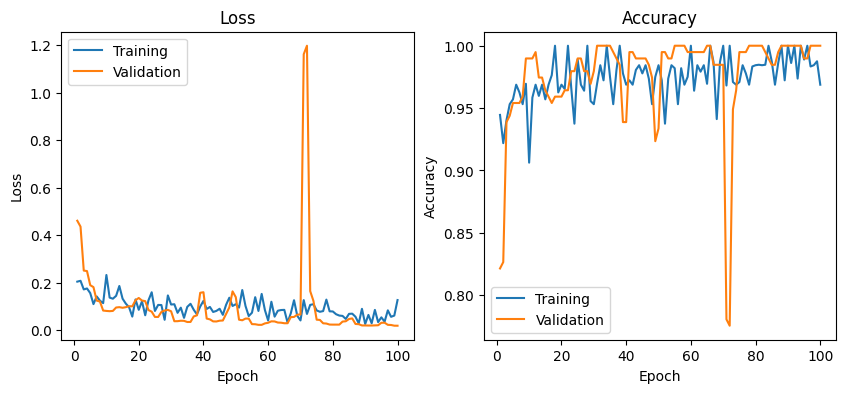

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9861 - loss: 0.0619
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9859 - loss: 0.0622 - val_accuracy: 1.0000 - val_loss: 0.0194
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9844 - loss: 0.0518
Epoch 2: val_accuracy did not improve from 1.00000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0518 - val_accuracy: 1.0000 - val_loss: 0.0194
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9911 - loss: 0.0570
Epoch 3: val_accuracy did not improve from 1.00000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9910 - loss: 0.0575 - val_accuracy: 1.0000 - val_loss: 0.0193
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0293
Epoch 4: val_accuracy did not improve from 1.00000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - lo

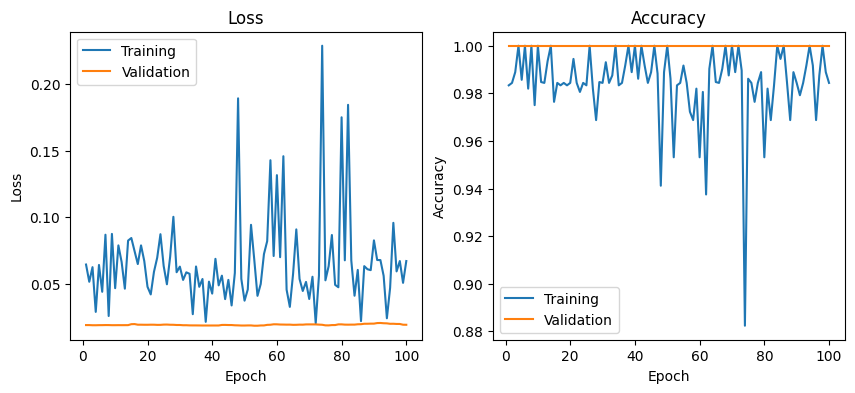

Fold #4 Test Accuracy: 1.0000

Processing Fold #5


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 24, 24, 32)     │            320 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_360   │ (None, 24, 24, 32)     │            128 │ conv2d_65[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_360            │ (None, 24, 24, 32)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 24, 24, 64)     │         18,496 │ activation_360[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_361   │ (None, 24, 24, 64)     │            256 │ conv2d_66[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_361            │ (None, 24, 24, 64)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_362            │ (None, 24, 24, 64)     │              0 │ activation_361[0][0]   │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_340      │ (None, 24, 24, 128)    │          8,896 │ activation_362[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_362   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_340[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_363            │ (None, 24, 24, 128)    │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_341      │ (None, 24, 24, 128)    │         17,664 │ activation_363[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_363   │ (None, 24, 24, 128)    │            512 │ separable_conv2d_341[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_40          │ (None, 12, 12, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)       

 Total params: 20,894,696 (79.71 MB)

 Trainable params: 20,844,440 (79.52 MB)

 Non-trainable params: 50,256 (196.31 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2100 - loss: 2.0581
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.2140 - loss: 2.0521 - val_accuracy: 0.2500 - val_loss: 2.0666
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3125 - loss: 1.8715
Epoch 2: val_accuracy did not improve from 0.25000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3125 - loss: 1.8715 - val_accuracy: 0.2500 - val_loss: 2.0658
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3150 - loss: 1.8539
Epoch 3: val_accuracy did not improve from 0.25000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3190 - loss: 1.8508 - val_accuracy: 0.2500 - val_loss: 2.0612
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5000 - loss: 1.5216
Epoch 4: val_accuracy did not improve from 0.25000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5000 - lo

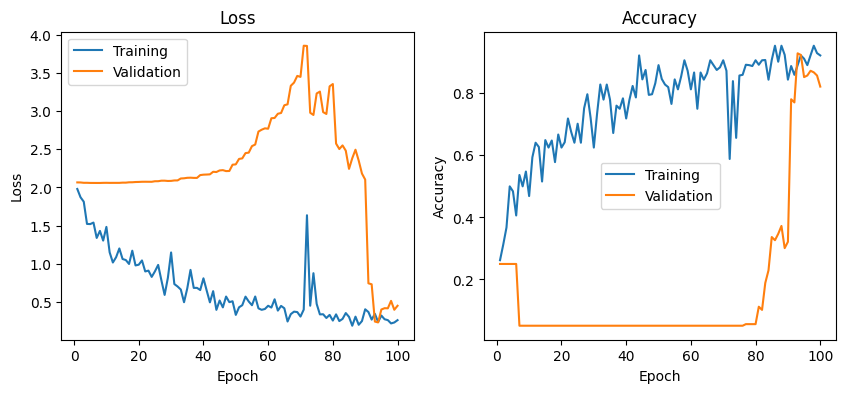

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9242 - loss: 0.2255
Epoch 1: val_accuracy improved from -inf to 0.92347, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9252 - loss: 0.2240 - val_accuracy: 0.9235 - val_loss: 0.1674
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9219 - loss: 0.2510
Epoch 2: val_accuracy improved from 0.92347 to 0.93878, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9219 - loss: 0.2510 - val_accuracy: 0.9388 - val_loss: 0.1608
Epoch 3/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9356 - loss: 0.1809
Epoch 3: val_accuracy improved from 0.93878 to 0.95408, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.9365 - loss: 0.1798 - val_accuracy: 0.9541 - val_loss: 0.1504
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9062 - loss: 0.2012
Epoch 4: val_ac

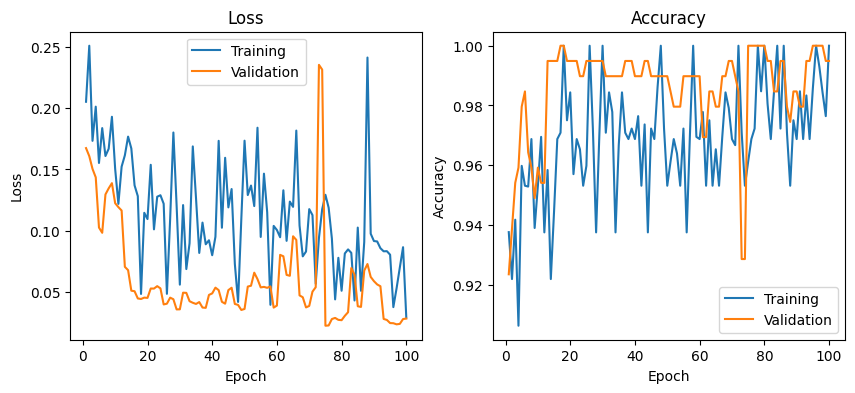

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9834 - loss: 0.0624
Epoch 1: val_accuracy improved from -inf to 0.99490, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9834 - loss: 0.0622 - val_accuracy: 0.9949 - val_loss: 0.0298
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9688 - loss: 0.1174
Epoch 2: val_accuracy did not improve from 0.99490
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.1174 - val_accuracy: 0.9949 - val_loss: 0.0299
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9885 - loss: 0.0557
Epoch 3: val_accuracy did not improve from 0.99490
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9879 - loss: 0.0572 - val_accuracy: 0.9949 - val_loss: 0.0292
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9844 - loss: 0.0808
Epoch 4: val_accuracy did not improve from 0.99490
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - lo

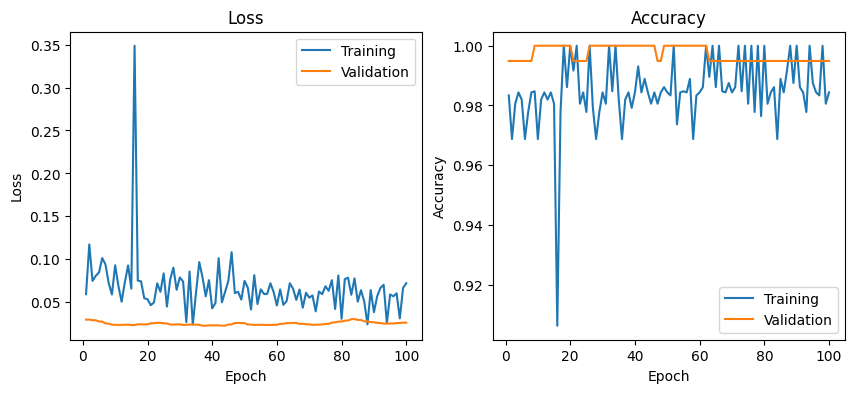

Fold #5 Test Accuracy: 0.9949

Mean Test Accuracy over 5 folds: 0.9847


In [4]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import gdown  # For Google Drive download

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Load dataset from directory (/kaggle/input/ckplus/CK+48) which contains 7 subfolders
dataset_path = '/kaggle/input/ckplus/CK+48'
class_names = sorted(os.listdir(dataset_path))
filepaths = []
labels = []
for idx, class_name in enumerate(class_names):
    folder = os.path.join(dataset_path, class_name)
    for fname in os.listdir(folder):
        file_path = os.path.join(folder, fname)
        filepaths.append(file_path)
        labels.append(idx)
        
filepaths = np.array(filepaths)
labels = np.array(labels)

# Load images (48x48 grayscale) and normalize
images = []
for fp in filepaths:
    img = load_img(fp, color_mode='grayscale', target_size=(48, 48))
    img_array = img_to_array(img)
    images.append(img_array)
images = np.array(images)
images = images / 255.0

# Convert labels to one-hot vectors (7 classes)
y = to_categorical(labels, num_classes=7)

# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define entry flow
def entry_flow(inputs):
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    return x

# Define middle flow
def middle_flow(x, num_blocks=8):
    previous_block_activation = x

    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.add([x, previous_block_activation])
        previous_block_activation = x

    return x

# Define attention layer
def attention_layer(inputs):
    attention = layers.Conv2D(1, (1, 1), activation="sigmoid")(inputs)
    return layers.multiply([inputs, attention])

# Define exit flow
def exit_flow(x, num_classes=7):
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = 'softmax' if num_classes > 1 else 'sigmoid'
    return layers.Dense(num_classes, activation=activation, kernel_regularizer=regularizers.l2(0.01))(x)

# 5-fold cross validation: Each fold uses 80% of data for training and 20% for test
kf = KFold(n_splits=5, shuffle=True, random_state=123)
fold_no = 1
test_accuracy_list = []

for train_index, test_index in kf.split(images):
    print(f"\nProcessing Fold #{fold_no}")
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create data generators
    batch_size = 64
    train_loader = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    
    # Build model
    inputs = keras.Input(shape=(48, 48, 1))
    x = entry_flow(inputs)
    x = middle_flow(x)
    x = attention_layer(x)  # Adding attention layer
    outputs = exit_flow(x)
    xception = keras.Model(inputs, outputs)
    
    # Print model summary
    xception.summary()
    
    # ------------------ First Training Block (LR = 0.001) ------------------
    opt = tf.keras.optimizers.Adam(0.001)
    xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                                 save_best_only=True, mode='max', verbose=1)
    
    epochs = 100
    h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                      validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])
    
    history = h1.history
    n_epochs = len(history['loss'])
    plt.figure(figsize=[10, 4])
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    # ------------------ Second Training Block (LR = 0.0001) ------------------
    opt = tf.keras.optimizers.Adam(0.0001)
    xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                                 save_best_only=True, mode='max', verbose=1)
    
    epochs = 100
    h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                      validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])
    
    history = h1.history
    n_epochs = len(history['loss'])
    plt.figure(figsize=[10, 4])
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    # ------------------ Third Training Block (LR = 0.00001) ------------------
    opt = tf.keras.optimizers.Adam(0.00001)
    xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                                 save_best_only=True, mode='max', verbose=1)
    
    epochs = 100
    h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                      validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])
    
    history = h1.history
    n_epochs = len(history['loss'])
    plt.figure(figsize=[10, 4])
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
    plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    # Evaluate the model on the test data for this fold
    scores = xception.evaluate(X_test, y_test, verbose=0)
    print(f"Fold #{fold_no} Test Accuracy: {scores[1]:.4f}")
    test_accuracy_list.append(scores[1])
    
    fold_no += 1

# Calculate and print the mean test accuracy over all folds
mean_test_accuracy = np.mean(test_accuracy_list)
print(f"\nMean Test Accuracy over 5 folds: {mean_test_accuracy:.4f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 24, 24, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 24, 24, 32)     │            128 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 24, 24, 32)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 24, 24, 64)     │         18,496 │ activation_36[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 24, 24, 64)     │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 24, 24, 64)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 24, 24, 64)     │              0 │ activation_37[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_34       │ (None, 24, 24, 128)    │          8,896 │ activation_38[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 24, 24, 128)    │            512 │ separable_conv2d_34[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 24, 24, 128)    │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_35       │ (None, 24, 24, 128)    │         17,664 │ activation_39[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 24, 24, 128)    │            512 │ separable_conv2d_35[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 12, 12, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)       

 Total params: 20,894,696 (79.71 MB)

 Trainable params: 20,844,440 (79.52 MB)

 Non-trainable params: 50,256 (196.31 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2530 - loss: 1.9917
Epoch 1: val_accuracy improved from -inf to 0.21320, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 483ms/step - accuracy: 0.2546 - loss: 1.9891 - val_accuracy: 0.2132 - val_loss: 2.0689
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 3:15 18s/step - accuracy: 0.3750 - loss: 1.9730
Epoch 2: val_accuracy did not improve from 0.21320
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.3750 - loss: 1.9730 - val_accuracy: 0.2132 - val_loss: 2.0685
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3314 - loss: 1.9166
Epoch 3: val_accuracy improved from 0.21320 to 0.25381, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.3336 - loss: 1.9121 - val_accuracy: 0.2538 - val_loss: 2.0646
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3906 - loss: 1.7067
Epoch 4: val_accuracy did not improve from 0.25381
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3906 - loss: 1.7067 - val_accuracy: 0.2538 - val_loss: 2.0643
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4330 - loss: 1.7079
Epoch 5: val_accuracy did not improve from 0.25381
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4325 - loss: 1.7101 - val_accuracy: 0.0558 - val_loss: 2.0610
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4531 - loss: 1.6025
Epoch 6: val_accuracy did not improve from 0.25381
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4531 - loss: 1.

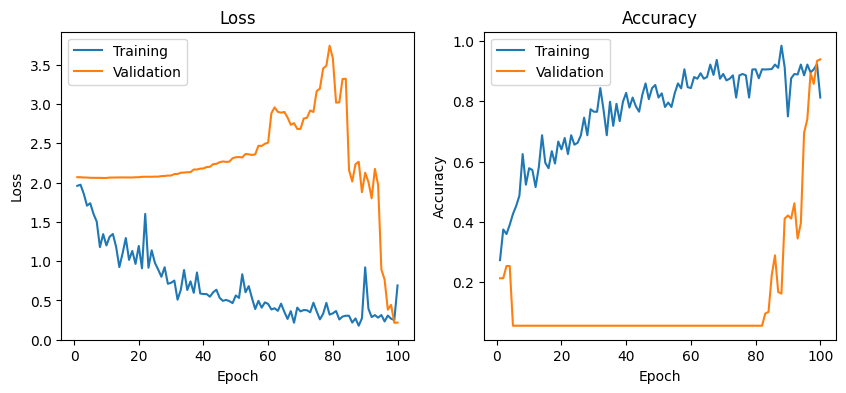

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9372 - loss: 0.1870
Epoch 1: val_accuracy improved from -inf to 0.96447, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9382 - loss: 0.1861 - val_accuracy: 0.9645 - val_loss: 0.1482
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8906 - loss: 0.2562
Epoch 2: val_accuracy did not improve from 0.96447
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8906 - loss: 0.2562 - val_accuracy: 0.9645 - val_loss: 0.1441
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9585 - loss: 0.1666
Epoch 3: val_accuracy did not improve from 0.96447
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9577 - loss: 0.1681 - val_accuracy: 0.9594 - val_loss: 0.1330
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9375 - loss: 0.2106
Epoch 4: val_accuracy did not improve from 0.96447
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - lo

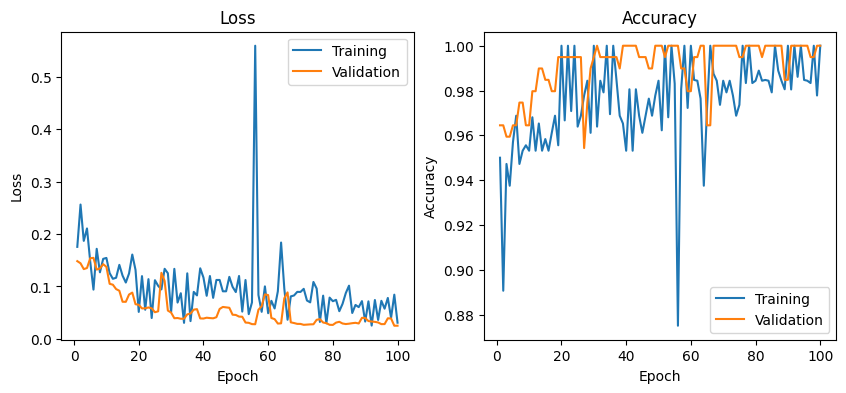

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9888 - loss: 0.0516
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9885 - loss: 0.0522 - val_accuracy: 1.0000 - val_loss: 0.0265
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9688 - loss: 0.0693
Epoch 2: val_accuracy did not improve from 1.00000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0693 - val_accuracy: 1.0000 - val_loss: 0.0266
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9885 - loss: 0.0682
Epoch 3: val_accuracy did not improve from 1.00000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9886 - loss: 0.0672 - val_accuracy: 1.0000 - val_loss: 0.0268
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0369
Epoch 4: val_accuracy did not improve from 1.00000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - lo

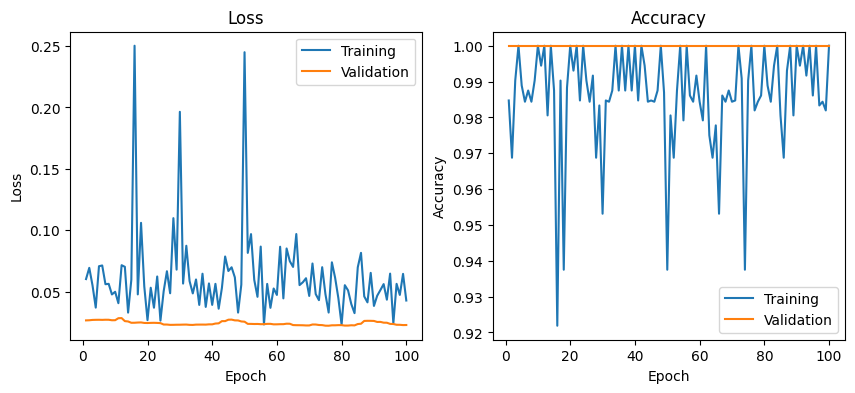

Test Accuracy: 1.0000


In [2]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import gdown  # For Google Drive download

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Load dataset from directory (/kaggle/input/ckplus/CK+48) which contains 7 subfolders
dataset_path = '/kaggle/input/ckplus/CK+48'
class_names = sorted(os.listdir(dataset_path))
filepaths = []
labels = []
for idx, class_name in enumerate(class_names):
    folder = os.path.join(dataset_path, class_name)
    for fname in os.listdir(folder):
        file_path = os.path.join(folder, fname)
        filepaths.append(file_path)
        labels.append(idx)
        
filepaths = np.array(filepaths)
labels = np.array(labels)

# Load images (48x48 grayscale) and normalize them
images = []
for fp in filepaths:
    img = load_img(fp, color_mode='grayscale', target_size=(48, 48))
    img_array = img_to_array(img)
    images.append(img_array)
images = np.array(images)
images = images / 255.0

# Convert labels to one-hot vectors (7 classes)
y = to_categorical(labels, num_classes=7)

# Split the dataset into 80% training and 20% test data
# For stratification we use the original labels array.
X_train, X_test, y_train, y_test = train_test_split(
    images, y, test_size=0.2, random_state=123, stratify=labels)

# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define entry flow
def entry_flow(inputs):
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    return x

# Define middle flow
def middle_flow(x, num_blocks=8):
    previous_block_activation = x
    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.add([x, previous_block_activation])
        previous_block_activation = x

    return x

# Define attention layer
def attention_layer(inputs):
    attention = layers.Conv2D(1, (1, 1), activation="sigmoid")(inputs)
    return layers.multiply([inputs, attention])

# Define exit flow
def exit_flow(x, num_classes=7):
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = 'softmax' if num_classes > 1 else 'sigmoid'
    return layers.Dense(num_classes, activation=activation, kernel_regularizer=regularizers.l2(0.01))(x)

# Build the model
inputs = keras.Input(shape=(48, 48, 1))
x = entry_flow(inputs)
x = middle_flow(x)
x = attention_layer(x)  # Adding attention layer
outputs = exit_flow(x)
xception = keras.Model(inputs, outputs)

# Print model summary
xception.summary()

# ------------------ First Training Block (LR = 0.001) ------------------
batch_size = 64
train_loader = train_datagen.flow(X_train, y_train, batch_size=batch_size)

opt = tf.keras.optimizers.Adam(0.001)
xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

epochs = 100
h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                  validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])

history = h1.history
n_epochs = len(history['loss'])
plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

# ------------------ Second Training Block (LR = 0.0001) ------------------
opt = tf.keras.optimizers.Adam(0.0001)
xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

epochs = 100
h2 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                  validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])

history = h2.history
n_epochs = len(history['loss'])
plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

# ------------------ Third Training Block (LR = 0.00001) ------------------
opt = tf.keras.optimizers.Adam(0.00001)
xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

epochs = 100
h3 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                  validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])

history = h3.history
n_epochs = len(history['loss'])
plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test data
scores = xception.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {scores[1]:.4f}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 24, 24, 32)     │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 24, 24, 32)     │            128 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_72             │ (None, 24, 24, 32)     │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 24, 24, 64)     │         18,496 │ activation_72[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 24, 24, 64)     │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_73             │ (None, 24, 24, 64)     │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_74             │ (None, 24, 24, 64)     │              0 │ activation_73[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_68       │ (None, 24, 24, 128)    │          8,896 │ activation_74[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 24, 24, 128)    │            512 │ separable_conv2d_68[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_75             │ (None, 24, 24, 128)    │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_69       │ (None, 24, 24, 128)    │         17,664 │ activation_75[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 24, 24, 128)    │            512 │ separable_conv2d_69[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 12, 12, 128)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)       

 Total params: 20,893,967 (79.70 MB)

 Trainable params: 20,843,711 (79.51 MB)

 Non-trainable params: 50,256 (196.31 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2120 - loss: 2.0699  
Epoch 1: val_accuracy improved from -inf to 0.25381, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.2155 - loss: 2.0676 - val_accuracy: 0.2538 - val_loss: 2.0690
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2969 - loss: 1.8726
Epoch 2: val_accuracy did not improve from 0.25381
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2969 - loss: 1.8726 - val_accuracy: 0.2538 - val_loss: 2.0682
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3559 - loss: 1.8184
Epoch 3: val_accuracy did not improve from 0.25381
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3577 - loss: 1.8142 - val_accuracy: 0.2538 - val_loss: 2.0640
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3750 - loss: 1.7225
Epoch 4: val_accuracy did not improve from 0.25381
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3750 - loss: 1.7225 - val_accuracy: 0.2538 - val_loss: 2.0639
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4813 - loss: 1.5224
Epoch 5: val_accuracy did not improve from 0.25381
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4842 - loss: 1.5143 - val_accuracy: 0.2538 - val_loss: 2.0629
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5625 - loss: 1.3000
Epoch 6: val_accuracy did not improve from 0.25381
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5625 - loss: 1.3000 - val_accuracy: 0.0863 - val_loss: 2.0628
Ep

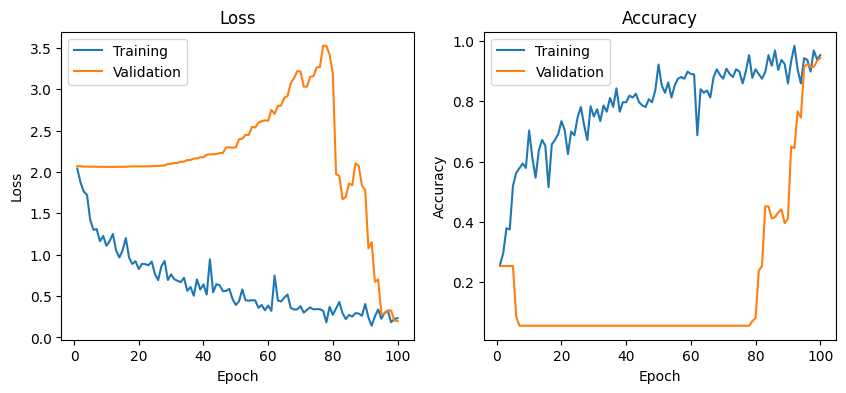

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9367 - loss: 0.2008
Epoch 1: val_accuracy improved from -inf to 0.96447, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9369 - loss: 0.2005 - val_accuracy: 0.9645 - val_loss: 0.1677
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9688 - loss: 0.1166
Epoch 2: val_accuracy did not improve from 0.96447
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.1166 - val_accuracy: 0.9645 - val_loss: 0.1644
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9506 - loss: 0.1895
Epoch 3: val_accuracy did not improve from 0.96447
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9505 - loss: 0.1887 - val_accuracy: 0.9442 - val_loss: 0.1870
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9531 - loss: 0.1744
Epoch 4: val_accuracy did not improve from 0.96447
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - lo

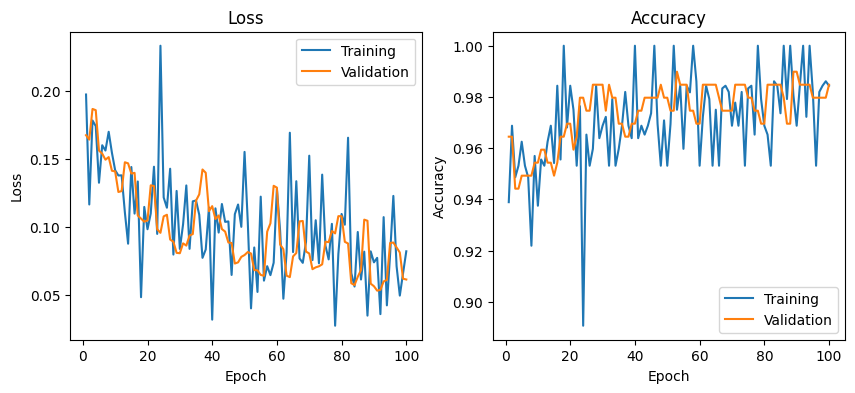

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9895 - loss: 0.0526  
Epoch 1: val_accuracy improved from -inf to 0.97970, saving model to bestXceptionPlusData.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9892 - loss: 0.0529 - val_accuracy: 0.9797 - val_loss: 0.0653
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9531 - loss: 0.1342
Epoch 2: val_accuracy did not improve from 0.97970
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.1342 - val_accuracy: 0.9797 - val_loss: 0.0653
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9869 - loss: 0.0653
Epoch 3: val_accuracy did not improve from 0.97970
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9862 - loss: 0.0667 - val_accuracy: 0.9797 - val_loss: 0.0650
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9688 - loss: 0.0502
Epoch 4: val_accuracy did not improve from 0.97970
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - 

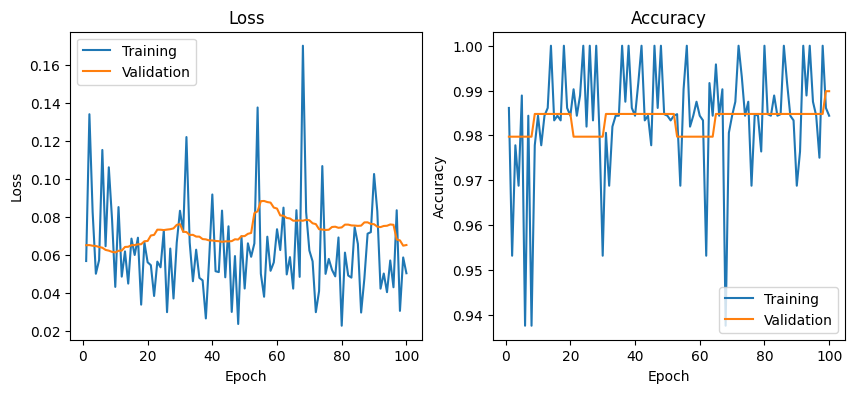

Test Accuracy: 0.9898


In [3]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import gdown  # For Google Drive download

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Load dataset from directory (/kaggle/input/ckplus/CK+48) which contains 7 subfolders
dataset_path = '/kaggle/input/ckplus/CK+48'
class_names = sorted(os.listdir(dataset_path))
filepaths = []
labels = []
for idx, class_name in enumerate(class_names):
    folder = os.path.join(dataset_path, class_name)
    for fname in os.listdir(folder):
        file_path = os.path.join(folder, fname)
        filepaths.append(file_path)
        labels.append(idx)
        
filepaths = np.array(filepaths)
labels = np.array(labels)

# Load images (48x48 grayscale) and normalize them
images = []
for fp in filepaths:
    img = load_img(fp, color_mode='grayscale', target_size=(48, 48))
    img_array = img_to_array(img)
    images.append(img_array)
images = np.array(images)
images = images / 255.0

# Convert labels to one-hot vectors (7 classes)
y = to_categorical(labels, num_classes=7)

# Split the dataset into 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(
    images, y, test_size=0.2, random_state=123, stratify=labels)

# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define entry flow
def entry_flow(inputs):
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    return x

# Define middle flow
def middle_flow(x, num_blocks=8):
    previous_block_activation = x
    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.add([x, previous_block_activation])
        previous_block_activation = x

    return x

# Define exit flow
def exit_flow(x, num_classes=7):
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = 'softmax' if num_classes > 1 else 'sigmoid'
    return layers.Dense(num_classes, activation=activation, kernel_regularizer=regularizers.l2(0.01))(x)

# Build the model (attention mechanism removed)
inputs = keras.Input(shape=(48, 48, 1))
x = entry_flow(inputs)
x = middle_flow(x)
outputs = exit_flow(x)
xception = keras.Model(inputs, outputs)

# Print model summary
xception.summary()

# ------------------ First Training Block (LR = 0.001) ------------------
batch_size = 64
train_loader = train_datagen.flow(X_train, y_train, batch_size=batch_size)

opt = tf.keras.optimizers.Adam(0.001)
xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

epochs = 100
h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                  validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])

history = h1.history
n_epochs = len(history['loss'])
plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

# ------------------ Second Training Block (LR = 0.0001) ------------------
opt = tf.keras.optimizers.Adam(0.0001)
xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

epochs = 100
h2 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                  validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])

history = h2.history
n_epochs = len(history['loss'])
plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

# ------------------ Third Training Block (LR = 0.00001) ------------------
opt = tf.keras.optimizers.Adam(0.00001)
xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
checkpoint = ModelCheckpoint('bestXceptionPlusData.keras', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

epochs = 100
h3 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                  validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])

history = h3.history
n_epochs = len(history['loss'])
plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), history['loss'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs + 1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test data
scores = xception.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {scores[1]:.4f}")
